In [1]:
import vectorbtpro as vbt
vbt.settings.set_theme("dark")

import pandas as pd
import numpy as np
from numba import njit

In [2]:
# Fetch data

def date_parser(timestamps):
    # First column are integer timestamps, parse them into DatetimeIndex
    return pd.to_datetime(timestamps, utc=True, unit="ms")

data = vbt.CSVData.fetch("download/xauusd-m1-bid-2021-09-01-2023-03-14.csv", date_parser=date_parser)

print(data.wrapper.shape)

(485280, 4)


In [3]:
# Fetch signals
signal_data = vbt.CSVData.fetch("download/TG_Extracted_Signals.csv", index_col=1)

print(signal_data.wrapper.shape)

(538, 10)


In [4]:
# Numba doesn't understand strings, thus create an enumerated type for stop types
from collections import namedtuple

# Create a type first
OrderTypeT = namedtuple("OrderTypeT", ["BUY", "SELL", "BUYSTOP", "SELLSTOP"])

# Then create a tuple
OrderType = OrderTypeT(*range(len(OrderTypeT._fields)))

print(OrderType)

OrderTypeT(BUY=0, SELL=1, BUYSTOP=2, SELLSTOP=3)


In [5]:
# Prepare signals

def transform_signal_data(df):
    # Select only one symbol, the one we fetched the data for
    df = df[df["Symbol"] == "XAUUSD"]
    
    # Select columns of interest
    df = df.iloc[:, -7:]
    
    # Map order types using OrderType
    df["OrderType"] = df["OrderType"].map(lambda x: OrderType._fields.index(x.replace(" ", "")))
    
    # Some entry prices are zero
    df = df[df["EntryPrice"] > 0]
    
    return df

signal_data = signal_data.transform(transform_signal_data)

print(signal_data.wrapper.shape)

(225, 7)


In [6]:
# Create named tuples which will act as containers for various arrays

# SignalInfo will contain signal information in a vbt-friendly format
# Rows in each array correspond to signals
SignalInfo = namedtuple("SignalInfo", [
    "timestamp",  # 1d array with timestamps in nanosecond format (int64)
    "order_type",  # 1d array with order types in integer format (int64, see order_type_map)
    "entry_price",  # 1d array with entry price (float64)
    "sl",  # 2d array where columns are SL levels (float64)
    "tp",  # 2d array where columns are TP levels (float64)
])

# TempInfo will contain temporary information that will be written during backtesting
# You can imagine being buffer that we write and then access at a later time
# Rows in each array correspond to signals
TempInfo = namedtuple("TempInfo", [
    "ts_bar",  # 1d array with row indices where signal was hit (int64)
    "entry_price_bar",  # 1d array with row indices where entry price was hit (int64)
    "sl_bar",  # 2d array with row indices where each SL level was hit, same shape as SignalInfo.sl (int64)
    "tp_bar",  # 2d array with row indices where each TP level was hit, same shape as SignalInfo.tp (int64)
])

In [7]:
# Here's what we will do:
# Represent each signal as a separate column with its own starting capital
# Run an order function using Portfolio.from_order_func
# The order function is executed at each bar and column (signal in our case)
# If the current bar contains a signal, execute the signal logic
# Order functions can issue only one order at bar, thus we if multiple stops were hit, we will aggregate them
# We will go all in and then gradually reduce the position based on the number of stops

@njit
def has_data_nb(c):
    # Numba function to check whether OHLC is not NaN
    if np.isnan(vbt.pf_nb.select_nb(c, c.open)):
        return False
    if np.isnan(vbt.pf_nb.select_nb(c, c.high)):
        return False
    if np.isnan(vbt.pf_nb.select_nb(c, c.low)):
        return False
    if np.isnan(vbt.pf_nb.select_nb(c, c.close)):
        return False
    return True

@njit
def check_price_hit_nb(c, price, hit_below, can_use_ohlc):
    # Numba function to check whether a price level was hit during this bar
    # Use hit_below=True to check against low and hit_below=False to check against high
    # If can_use_ohlc is False, will check only against the close price
    
    order_price, hit_on_open, hit = vbt.pf_nb.check_price_hit_nb(
        open=vbt.pf_nb.select_nb(c, c.open),  # OHLC are flexible arrays, always use select_nb!
        high=vbt.pf_nb.select_nb(c, c.high),
        low=vbt.pf_nb.select_nb(c, c.low),
        close=vbt.pf_nb.select_nb(c, c.close),
        price=price,
        hit_below=hit_below,
        can_use_ohlc=can_use_ohlc
    )
    # Order price here isn't necessarily the price that has been hit
    # For example, if the price was hit before open, order price is set to the open price
    return order_price, hit

@njit(boundscheck=True)
def order_func_nb(c, signal_info, temp_info):  # first argument is context, other are our containers
    if not has_data_nb(c):
        # If this bar contains no data, skip it
        return vbt.pf_nb.order_nothing_nb()
    
    # Each column corresponds to a signal
    signal = c.col
    
    # Each row corresponds to a bar
    bar = c.i
    
    # Define various flags for pure convenience
    buy_market = signal_info.order_type[signal] == OrderType.BUY
    sell_market = signal_info.order_type[signal] == OrderType.SELL
    buy_stop = signal_info.order_type[signal] == OrderType.BUYSTOP
    sell_stop = signal_info.order_type[signal] == OrderType.SELLSTOP
    buy = buy_market or buy_stop
    
    # First, we need to check whether the current bar contains a signal
    can_use_ohlc = True
    if temp_info.ts_bar[signal] == -1:
        if c.index[bar] == signal_info.timestamp[signal]:
            # If so, store the current row index in a temporary array
            # such that later we know that we already discovered a signal
            temp_info.ts_bar[signal] = bar

            # The signal has the granularity of seconds, thus it belongs somewhere in the bar
            # We need to notify the functions below that they cannot use full OHLC information, only close
            # This is to avoid using prices that technically happened before the signal
            can_use_ohlc = False
        
    # Here comes the entry order
    # Check whether the signal has been discovered
    # -1 means hasn't been discovered yet
    if temp_info.ts_bar[signal] != -1:
        
        # Then, check whether the entry order hasn't been executed
        if temp_info.entry_price_bar[signal] == -1:
            
            # If so, execute the entry order
            if buy_market:
                # Buy market order (using closing price)
                
                # Store the current row index in a temporary array such that future bars know
                # that the order has already been executed
                temp_info.entry_price_bar[signal] = bar
                order_price = signal_info.entry_price[signal]
                return vbt.pf_nb.order_nb(np.inf, np.inf)  # size, price
            
            if sell_market:
                # Sell market order (using closing price)
                temp_info.entry_price_bar[signal] = bar
                order_price = signal_info.entry_price[signal]
                return vbt.pf_nb.order_nb(-np.inf, np.inf)
            
            if buy_stop:
                # Buy stop order
                # A buy stop order is entered at a stop price above the current market price
                
                # Since it's a pending order, we first need to check whether the entry price has been hit
                order_price, hit = check_price_hit_nb(
                    c,
                    price=signal_info.entry_price[signal],
                    hit_below=False,
                    can_use_ohlc=can_use_ohlc,
                )
                if hit:
                    # If so, execute the order
                    temp_info.entry_price_bar[signal] = bar
                    return vbt.pf_nb.order_nb(np.inf, order_price)
                
            if sell_stop:
                # Sell stop order
                # A sell stop order is entered at a stop price below the current market price
                order_price, hit = check_price_hit_nb(
                    c,
                    price=signal_info.entry_price[signal],
                    hit_below=True,
                    can_use_ohlc=can_use_ohlc,
                )
                if hit:
                    temp_info.entry_price_bar[signal] = bar
                    return vbt.pf_nb.order_nb(-np.inf, order_price)
               
        # Here comes the stop order
        # Check whether the entry order has been executed
        if temp_info.entry_price_bar[signal] != -1:
            
            # We also need to check whether we're still in a position
            # in case stops have already closed out the position
            if c.last_position[signal] != 0:
                
                # If so, start with checking for potential SL orders
                # (remember that SL pessimistically comes before TP)
                # First, we need to know the number of potential and already executed SL levels
                # since we want to gradually reduce the position proportially to the number of levels
                # For example, one signal may define [12.35, 12.29] and another [17.53, nan]
                n_sl_levels = 0
                n_sl_hits = 0
                sl_levels = signal_info.sl[signal]  # select 1d array from 2d array
                sl_bar = temp_info.sl_bar[signal]  # same here
                for k in range(len(sl_levels)):
                    if not np.isnan(sl_levels[k]):
                        n_sl_levels += 1
                    if sl_bar[k] != -1:
                        n_sl_hits += 1
                
                # We can execute only one order at the current bar
                # Thus, if the price crossed multiple SL levels, we need to pack them into one order
                # Since SL levels are guaranteed to be sorted, we will check the most distant levels first
                # because if a distant stop has been hit, the closer stops are automatically hit too
                for k in range(n_sl_levels - 1, n_sl_hits - 1, -1):
                    if not np.isnan(sl_levels[k]) and sl_bar[k] == -1:
                        # Check against low for buy orders and against high for sell orders
                        order_price, hit = check_price_hit_nb(
                            c,
                            price=sl_levels[k],
                            hit_below=buy,
                            can_use_ohlc=can_use_ohlc,
                        )
                        if hit:
                            sl_bar[k] = bar
                            # The further away the stop is, the more of the position needs to be closed
                            # We will specify a target percentage
                            # For example, for two stops it would be 0.5 (SL1) and 0.0 (SL2)
                            # while for three stops it would be 0.66 (SL1), 0.33 (SL2), and 0.0 (SL3)
                            # This works only if we went all in before (size=np.inf)!
                            size = 1 - (k + 1) / n_sl_levels
                            size_type = vbt.pf_enums.SizeType.TargetPercent
                            if buy:
                                return vbt.pf_nb.order_nb(size, order_price, size_type)
                            else:
                                # Size must be negative for short positions
                                return vbt.pf_nb.order_nb(-size, order_price, size_type)
                        
                # Same for potential TP orders
                n_tp_levels = 0
                n_tp_hits = 0
                tp_levels = signal_info.tp[signal]
                tp_bar = temp_info.tp_bar[signal]
                for k in range(len(tp_levels)):
                    if not np.isnan(tp_levels[k]):
                        n_tp_levels += 1
                    if tp_bar[k] != -1:
                        n_tp_hits += 1
                
                for k in range(n_tp_levels - 1, n_tp_hits - 1, -1):
                    if not np.isnan(tp_levels[k]) and tp_bar[k] == -1:
                        # Check against high for buy orders and against low for sell orders
                        order_price, hit = check_price_hit_nb(
                            c,
                            price=tp_levels[k],
                            hit_below=not buy,
                            can_use_ohlc=can_use_ohlc,
                        )
                        if hit:
                            tp_bar[k] = bar
                            size = 1 - (k + 1) / n_tp_levels
                            size_type = vbt.pf_enums.SizeType.TargetPercent
                            if buy:
                                return vbt.pf_nb.order_nb(size, order_price, size_type)
                            else:
                                return vbt.pf_nb.order_nb(-size, order_price, size_type)
                    
    # If neither of orders has been executed, order nothing
    return vbt.pf_nb.order_nothing_nb()

In [8]:
# Prepare signal information

timestamp = vbt.dt.to_ns(signal_data.index)  # nanoseconds
order_type = signal_data.get("OrderType").values
entry_price = signal_data.get("EntryPrice").values
sl = signal_data.get("SL").values
tp1 = signal_data.get("TP1").values
tp2 = signal_data.get("TP2").values
tp3 = signal_data.get("TP3").values
tp4 = signal_data.get("TP4").values

n_signals = len(timestamp)
print(n_signals)

225


In [9]:
# Since the signals are of the second granularity while the data is of the minute granularity,
# we need to round the timestamp of the signal to the nearest minute
# Timestamps represent the opening time, thus the second "19:28:59" belongs to the minute "19:28:00"

timestamp = timestamp - timestamp % vbt.dt_nb.m_ns

In [10]:
# Create a named tuple for signal information

signal_info = SignalInfo(
    timestamp=timestamp,
    order_type=order_type,
    entry_price=entry_price,
    sl=np.column_stack((sl,)),
    tp=np.column_stack((tp1, tp2, tp3, tp4))
)

n_sl_levels = signal_info.sl.shape[1]
print(n_sl_levels)

n_tp_levels = signal_info.tp.shape[1]
print(n_tp_levels)

1
4


In [11]:
# Important: re-run this cell every time you're running the simulation!
# Create a named tuple for temporary information
# All arrays below hold row indices, thus the default value is -1

def build_temp_info(signal_info):
    return TempInfo(
        ts_bar=np.full(len(signal_info.timestamp), -1),
        entry_price_bar=np.full(len(signal_info.timestamp), -1),
        sl_bar=np.full(signal_info.sl.shape, -1),
        tp_bar=np.full(signal_info.tp.shape, -1)
    )

temp_info = build_temp_info(signal_info)

In [12]:
# By default, vectorbt initializes an empty order array of the same shape as data
# But since our data is highly granular, it would take a lot of RAM
# Let's limit the number of records to one entry order and the maximum number of SL and TP orders
# It will be applied per column

max_orders = 1 + n_sl_levels + n_tp_levels

print(max_orders)

6


In [13]:
# Perform the actual simulation
# Since we don't broadcast data against any other array, vectorbt doesn't know anything about
# our signal arrays and will simulate only the one column in our data
# Thus, we need to tell it to expand the number of columns by the number of signals using tiling
# But don't worry: thanks to flexible indexing vectorbt won't actually tile the data - good for RAM!
# (it would tile the data if it had multiple columns though!)

pf = vbt.Portfolio.from_order_func(
    data,
    order_func_nb=order_func_nb,
    order_args=(signal_info, temp_info),
    broadcast_kwargs=dict(tile=n_signals),  # tiling here
    max_orders=max_orders,
    freq="minute"  # we have an irregular one-minute frequency
)
# (may take a minute...)

In [14]:
# Let's print out the order records in a human-readable format

print(pf.orders.records_readable)

     Order Id  Column                     Index      Size     Price  Fees  \
0           0       0 2021-09-14 12:43:00+00:00  0.055835  1790.994   0.0   
1           1       0 2021-09-14 12:44:00+00:00  0.018612  1790.900   0.0   
2           2       0 2021-09-14 12:46:00+00:00  0.018597  1789.400   0.0   
3           3       0 2021-09-14 12:55:00+00:00  0.018626  1796.400   0.0   
4           0       3 2021-09-16 10:39:00+00:00  0.056191  1779.634   0.0   
..        ...     ...                       ...       ...       ...   ...   
432         3     221 2023-03-09 14:39:00+00:00  0.027615  1830.000   0.0   
433         0     222 2023-03-09 08:48:00+00:00  0.055008  1817.918   0.0   
434         1     222 2023-03-09 14:34:00+00:00  0.055008  1828.000   0.0   
435         0     223 2023-03-09 14:26:00+00:00  0.054760  1826.135   0.0   
436         1     223 2023-03-09 15:07:00+00:00  0.054760  1835.000   0.0   

     Side  
0    Sell  
1     Buy  
2     Buy  
3     Buy  
4     Buy  
.. 

In [15]:
# We can notice above that there's no information whether an order is an SL or TP order
# What we can do is to create our own order records with custom fields, copy the old ones over,
# and tell the portfolio to use them instead of the default ones

# First, we need to create an enumerated field for stop types
# SL levels will come first, TP levels second, in an incremental fashion
StopTypeT = namedtuple("StopTypeT", [
    *[f"SL{i + 1}" for i in range(n_sl_levels)],
    *[f"TP{i + 1}" for i in range(n_tp_levels)]
])
StopType = StopTypeT(*range(len(StopTypeT._fields)))

print(StopType)

StopTypeT(SL1=0, TP1=1, TP2=2, TP3=3, TP4=4)


In [16]:
# To extend order records, we just need to append new fields and construct a new data type

custom_order_dt = np.dtype(vbt.pf_enums.order_fields + [("order_type", np.int_), ("stop_type", np.int_)])

def fix_order_records(order_records, signal_info, temp_info):
    # This is a function that will "fix" our default records and return the fixed ones
    
    # Create a new empty record array with the new data type
    # Empty here means that the array isn't initialized yet and contains junk data
    # Thus, make sure to override each single element
    custom_order_records = np.empty(order_records.shape, dtype=custom_order_dt)
    
    # Copy over the information from our default records
    for field, _ in vbt.pf_enums.order_fields:
        custom_order_records[field] = order_records[field]
        
    # Iterate over the new records and fill the stop type
    for i in range(len(custom_order_records)):
        record = custom_order_records[i]
        signal = record["col"]  # each column corresponds to a signal
        
        # Fill the order type
        record["order_type"] = signal_info.order_type[signal]
        
        # Concatenate SL and TP row indices of this signal into a new list
        # We must do it the same way as we did in StopTypeT
        bar = [
            *temp_info.sl_bar[signal],
            *temp_info.tp_bar[signal]
        ]
        
        # Check whether the row index of this order is in this list
        # (which means that this order is a stop order)
        if record["idx"] in bar:
            # If so, get the matching position in this list and use it as order type
            # It will correspond to a field in StopType
            record["stop_type"] = bar.index(record["idx"])
        else:
            record["stop_type"] = -1
    return custom_order_records
            
custom_order_records = fix_order_records(pf.order_records, signal_info, temp_info)
print(custom_order_records[:10])

[(0, 0, 13723, 0.05583492, 1790.994, 0., 1, 1, -1)
 (1, 0, 13724, 0.01861164, 1790.9  , 0., 0, 1,  1)
 (2, 0, 13726, 0.01859683, 1789.4  , 0., 0, 1,  2)
 (3, 0, 13735, 0.01862645, 1796.4  , 0., 0, 1,  0)
 (0, 3, 15039, 0.05619133, 1779.634, 0., 0, 0, -1)
 (1, 3, 18200, 0.02809566, 1781.3  , 0., 1, 0,  1)
 (2, 3, 41058, 0.02809566, 1783.3  , 0., 1, 0,  2)
 (0, 4, 15168, 0.05672607, 1762.858, 0., 0, 0, -1)
 (1, 4, 15173, 0.01890869, 1763.8  , 0., 1, 0,  1)
 (2, 4, 15209, 0.03781738, 1758.3  , 0., 1, 0,  0)]


In [17]:
# Having raw order records is not enough as vbt.Orders doesn't know what to do with the new field
# (remember that vbt.Orders is used to analyze the records)
# Let's create our custom class that subclasses vbt.Orders
# and override the field config to also include the information on the new field

from vectorbtpro.records.decorators import attach_fields, override_field_config

@attach_fields(dict(stop_type=dict(attach_filters=True)))
@override_field_config(dict(
    dtype=custom_order_dt,  # specify the new data type
    settings=dict(
        order_type=dict(
            title="Order Type",  # specify a human-readable title for the field
            mapping=OrderType,  # specify the mapper for the field
        ),
        stop_type=dict(
            title="Stop Type",  # specify a human-readable title for the field
            mapping=StopType,  # specify the mapper for the field
        ),
    )
))
class CustomOrders(vbt.Orders):
    pass

In [18]:
# Finally, let's replace the order records and the class in the portfolio

pf = pf.replace(order_records=custom_order_records, orders_cls=CustomOrders)

In [19]:
# We can now effortlessly analyze the stop type

print(pf.orders.records_readable)

     Order Id  Column                     Index      Size     Price  Fees  \
0           0       0 2021-09-14 12:43:00+00:00  0.055835  1790.994   0.0   
1           1       0 2021-09-14 12:44:00+00:00  0.018612  1790.900   0.0   
2           2       0 2021-09-14 12:46:00+00:00  0.018597  1789.400   0.0   
3           3       0 2021-09-14 12:55:00+00:00  0.018626  1796.400   0.0   
4           0       3 2021-09-16 10:39:00+00:00  0.056191  1779.634   0.0   
..        ...     ...                       ...       ...       ...   ...   
432         3     221 2023-03-09 14:39:00+00:00  0.027615  1830.000   0.0   
433         0     222 2023-03-09 08:48:00+00:00  0.055008  1817.918   0.0   
434         1     222 2023-03-09 14:34:00+00:00  0.055008  1828.000   0.0   
435         0     223 2023-03-09 14:26:00+00:00  0.054760  1826.135   0.0   
436         1     223 2023-03-09 15:07:00+00:00  0.054760  1835.000   0.0   

     Side Order Type Stop Type  
0    Sell       SELL      None  
1     Buy

In [20]:
# And here are the signals that correspond to these records for verification

print(signal_data.get())

                           OrderType  EntryPrice      SL     TP1     TP2  \
date                                                                       
2021-09-14 12:43:51+00:00          1      1792.4  1796.4  1790.9  1789.4   
2021-09-15 04:24:47+00:00          0      1800.0  1797.5  1805.0  1810.0   
2021-09-15 08:08:45+00:00          1      1802.5  1806.5  1801.0  1799.5   
2021-09-16 10:39:52+00:00          0      1780.0     NaN  1781.3  1783.3   
2021-09-16 12:48:36+00:00          0      1762.3  1758.3  1763.8  1765.3   
...                              ...         ...     ...     ...     ...   
2023-03-08 15:15:01+00:00          1      1820.0  1830.0  1817.0  1812.0   
2023-03-08 15:38:05+00:00          1      1823.0  1830.0  1820.0  1815.0   
2023-03-09 08:48:33+00:00          1      1818.0  1828.0  1815.0  1810.0   
2023-03-09 14:26:07+00:00          1      1827.0  1835.0  1824.0  1820.0   
2023-03-10 15:45:43+00:00          3      1865.0  1875.0  1862.0  1857.0   

           

In [21]:
# We can see that some signals were skipped, let's remove them from the portfolio

pf = pf.loc[:, pf.orders.count() >= 1]

print(len(pf.wrapper.columns))

127


In [22]:
# There are various ways to analyze the data
# For example, we can count how many times each stop type was triggered
# Since we want to combine all trades in each statistic, we need to provide grouping

print(pf.orders.stop_type.stats(group_by=True))

Start                 2021-09-01 00:00:00+00:00
End                   2023-03-11 23:59:00+00:00
Period                        337 days 00:00:00
Count                                       437
Value Counts: None                          127
Value Counts: SL1                            95
Value Counts: TP1                            96
Value Counts: TP2                            82
Value Counts: TP3                            29
Value Counts: TP4                             8
Name: group, dtype: object


In [23]:
# We can also get the position stats for P&L information

print(pf.positions.stats(group_by=True))

Start                         2021-09-01 00:00:00+00:00
End                           2023-03-11 23:59:00+00:00
Period                                337 days 00:00:00
First Trade Start             2021-09-14 12:43:00+00:00
Last Trade End                2023-03-09 15:07:00+00:00
Coverage                              183 days 13:36:00
Overlap Coverage                       86 days 11:37:00
Total Records                                       127
Total Long Trades                                    20
Total Short Trades                                  107
Total Closed Trades                                 126
Total Open Trades                                     1
Open Trade PnL                                 0.119989
Win Rate [%]                                  32.539683
Max Win Streak                                        1
Max Loss Streak                                       1
Best Trade [%]                                 2.541454
Worst Trade [%]                               -0

In [24]:
# Let's plot a random trade
# The only issue: we have too much data for that (thanks to Plotly)
# Thus, crop it before plotting to remove irrelevant data

signal = np.random.choice(len(pf.wrapper.columns))
pf.trades.iloc[:, signal].crop().plot().show_svg()

In [25]:
# Let's verify that the entry price stays within each candle

print(pd.concat((
    pf.orders.records_readable[["Column", "Order Type", "Stop Type", "Price"]],
    pf.orders.bar_high.to_readable(title="High", only_values=True),
    pf.orders.bar_low.to_readable(title="Low", only_values=True),
    pf.orders.price_status.to_readable(title="Price Status", only_values=True),
), axis=1))

print(pf.orders.price_status.stats(group_by=True))

     Column Order Type Stop Type     Price      High       Low Price Status
0         0       SELL      None  1790.994  1791.578  1790.694           OK
1         0       SELL       TP1  1790.900  1791.088  1789.848           OK
2         0       SELL       TP2  1789.400  1790.488  1789.234           OK
3         0       SELL       SL1  1796.400  1796.877  1794.507           OK
4         3        BUY      None  1779.634  1779.907  1779.324           OK
..      ...        ...       ...       ...       ...       ...          ...
432     221       SELL       SL1  1830.000  1830.075  1828.485           OK
433     222       SELL      None  1817.918  1818.098  1817.698           OK
434     222       SELL       SL1  1828.000  1828.345  1826.565           OK
435     223       SELL      None  1826.135  1826.595  1825.878           OK
436     223       SELL       SL1  1835.000  1835.565  1833.635           OK

[437 rows x 7 columns]
Start               2021-09-01 00:00:00+00:00
End               

In [26]:
# Now, what if we're interested in portfolio metrics, such as the Sharpe ratio?
# The problem is that most metrics are producing multiple (intermediate) time series 
# of the full shape, which is disastrous for RAM since our data will have to be tiled 
# by the number of columns. But here's a trick: merge order records of all columns into one, 
# as if we did the simulation on just one column!

def merge_order_records(order_records):
    merged_order_records = order_records.copy()
    
    # New records should have only one column
    merged_order_records["col"][:] = 0
    
    # Sort the records by the timestamp
    merged_order_records = merged_order_records[np.argsort(merged_order_records["idx"])]
    
    # Reset the order ids
    merged_order_records["id"][:] = np.arange(len(merged_order_records))
    return merged_order_records

merged_order_records = merge_order_records(custom_order_records)
print(merged_order_records[:10])

[(0, 0, 13723, 0.05583492, 1790.994, 0., 1, 1, -1)
 (1, 0, 13724, 0.01861164, 1790.9  , 0., 0, 1,  1)
 (2, 0, 13726, 0.01859683, 1789.4  , 0., 0, 1,  2)
 (3, 0, 13735, 0.01862645, 1796.4  , 0., 0, 1,  0)
 (4, 0, 15039, 0.05619133, 1779.634, 0., 0, 0, -1)
 (5, 0, 15168, 0.05672607, 1762.858, 0., 0, 0, -1)
 (6, 0, 15173, 0.01890869, 1763.8  , 0., 1, 0,  1)
 (7, 0, 15209, 0.03781738, 1758.3  , 0., 1, 0,  0)
 (8, 0, 16500, 0.05676728, 1761.578, 0., 0, 0, -1)
 (9, 0, 16610, 0.05676728, 1755.   , 0., 1, 0,  0)]


In [27]:
# We also need to change the wrapper because it holds the information on our columns

merged_wrapper = pf.wrapper.replace(columns=[0], ndim=1)

In [28]:
# Is there any other array that requires merging?
# Let's introspect the portfolio instance and search for arrays of the full shape

print(pf)

Portfolio(
    wrapper=ArrayWrapper(
        index=<pandas.core.indexes.datetimes.DatetimeIndex object at 0x7fdc0c0d02b0 with shape (485280,)>,
        columns=<pandas.core.indexes.numeric.Int64Index object at 0x7fdc0adc53d0 with shape (127,)>,
        ndim=2,
        freq='minute',
        column_only_select=None,
        range_only_select=None,
        group_select=None,
        grouped_ndim=None,
        grouper=Grouper(
            index=<pandas.core.indexes.numeric.Int64Index object at 0x7fdc0adc53d0 with shape (127,)>,
            group_by=None,
            def_lvl_name='group',
            allow_enable=True,
            allow_disable=True,
            allow_modify=True
        )
    ),
    order_records=<numpy.ndarray object at 0x7fdc29119210 with shape (437,)>,
    open=<numpy.ndarray object at 0x7fdc0c2d9f30 with shape (485280, 1)>,
    high=<numpy.ndarray object at 0x7fdc28e65f30 with shape (485280, 1)>,
    low=<numpy.ndarray object at 0x7fdc28e65e70 with shape (485280, 1)>,

In [29]:
# There are none, thus replace only the records and the wrapper
# Also, the previous individual portfolios were each using the starting capital of $100
# Which was used by 100%, but since we merge columns together, we now may require less starting capital
# Thus, we will determine it automatically

merged_pf = pf.replace(
    order_records=merged_order_records, 
    wrapper=merged_wrapper,
    init_cash="auto"
)

In [30]:
# We can now get any portfolio statistic

print(merged_pf.stats())

Start                         2021-09-01 00:00:00+00:00
End                           2023-03-11 23:59:00+00:00
Period                                337 days 00:00:00
Start Value                                  315.787606
Min Value                                    313.387374
Max Value                                     331.72069
End Value                                     323.73976
Total Return [%]                               2.518197
Benchmark Return [%]                           2.934614
Total Time Exposure [%]                       54.470821
Max Gross Exposure [%]                       100.448203
Max Drawdown [%]                               3.719242
Max Drawdown Duration                  83 days 02:09:00
Total Orders                                        437
Total Fees Paid                                     0.0
Total Trades                                        320
Win Rate [%]                                  63.636364
Best Trade [%]                                  

In [31]:
# You may wonder why the win rate and other trade metrics are different here
# There are two reasons: 
# 1) portfolio stats uses exit trades (previously we used positions), 
#     that is, each stop order is a trade
# 2) after merging, there's no more information which order belongs to which trade, 
#     thus positions are built in a sequential order

# But to verify that both portfolio match, we can compare to the total profit to the previous trade P&L
print(merged_pf.total_profit)
print(pf.trades.pnl.sum(group_by=True))

7.952153959905239
7.952153959905058


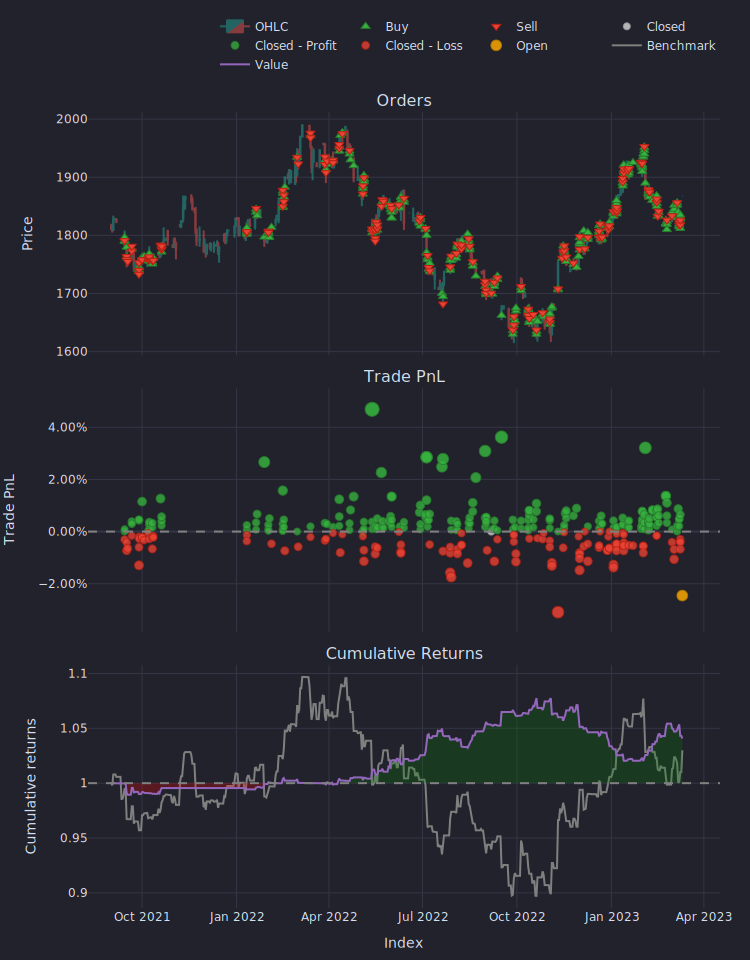

In [32]:
# We can now plot the entire portfolio

merged_pf.resample("daily").plot().show_svg()

In [33]:
# The main issue with using from_order_func is that we need to go over the entire data 
# as many times as there are signals because the order function is run on single each element
# A far more time-efficient approach would be processing trades in a sequential order
# This is easily possible because our trades are perfectly sorted - we don't need
# to process a signal if the previous signal hasn't been processed yet
# Also, because the scope of this notebook assumes that signals are independent, 
# we can simulate them independently and stop each signal's simulation once its position has been closed out
# This is only possible by writing an own simulator (which isn't as scary as it sounds!)

# To avoid duplicating our signal logic, we will re-use order_func_nb by passing our own limited context
# It will consist only of the fields that are required by our order_func_nb

OrderContext = namedtuple("OrderContext", [
    "i",
    "col",
    "index",
    "open",  
    "high",
    "low",
    "close",
    "last_position"
])

In [34]:
# Let's build the simulator
# Technically, it's just a regular Numba function that does whatever we want
# What's special about it is that it calls the vectorbt's low-level API to place orders and 
# updates the simulation state such as cash balances and positions
# We'll first determine the bars where the signals happen, and then run a smaller simulation
# on the first signal. Once the signal's position has been closed out, we'll terminate the simulation
# and continue with the next signal, until all signals are processed.

@njit(boundscheck=True)
def signal_simulator_nb(
    index, 
    open, 
    high, 
    low, 
    close, 
    signal_info,
    temp_info
):
    # Determine the number of signals, levels, and potential orders
    n_signals = len(signal_info.timestamp)
    n_sl_levels = signal_info.sl.shape[1]
    n_tp_levels = signal_info.tp.shape[1]
    max_orders = 1 + n_sl_levels + n_tp_levels
    
    # Temporary arrays
    
    # This array will hold the bar where each signal happens
    signal_bars = np.full(n_signals, -1, dtype=np.int_)
    
    # This array will hold order records
    # Initially, order records are uninitialized (junk data) but we will fill them gradually
    # Notice how we use our own data type custom_order_dt - we can fill order type and stop type 
    # fields right during the simulation
    order_records = np.empty((max_orders, n_signals), dtype=custom_order_dt)
    
    # To be able to distinguish between uninitialized and initialized (filled) orders,
    # we'll create another array holding the number of filled orders for each signal
    # For example, if order_records has a maximum of 6 rows and only one record is filled,
    # order_counts will be 1 for this signal, so vectorbt can remove 5 unfilled orders later
    order_counts = np.full(n_signals, 0, dtype=np.int_)
    
    # order_func_nb requires last_position, which holds the position of each signal
    last_position = np.full(n_signals, 0.0, dtype=np.float_)
    
    # First, we need to determine the bars where the signals happen
    # Even though we know their timestamps, we need to translate them into absolute indices
    signal = 0
    bar = 0
    while signal < n_signals and bar < len(index):
        if index[bar] == signal_info.timestamp[signal]:
            # If there's a match, save the bar and continue with the next signal on the next bar
            signal_bars[signal] = bar
            signal += 1
            bar += 1
        elif index[bar] > signal_info.timestamp[signal]:
            # If we're past the signal, continue with the next signal on the same bar
            signal += 1
        else:
            # If we haven't hit the signal yet, continue on the next bar
            bar += 1

    # Once we know the bars, we can iterate over signals in a loop and simulate them independently
    for signal in range(n_signals):
        
        # If there was no match in the previous level, skip the simulation
        from_bar = signal_bars[signal]
        if from_bar == -1:
            continue
            
        # This is our initial execution state, which holds the most important balances
        # We'll start with a starting capital of $100
        exec_state = vbt.pf_enums.ExecState(
            cash=100.0,
            position=0.0,
            debt=0.0,
            locked_cash=0.0,
            free_cash=100.0,
            val_price=np.nan,
            value=np.nan
        )
            
        # Here comes the actual simulation that starts from the signal's bar and
        # ends either once we processed all bars or once the position has been closed out (see below)
        for bar in range(from_bar, len(index)):
            
            # Create a named tuple holding the current context (this is "c" in order_func_nb)
            c = OrderContext(  
                i=bar,
                col=signal,
                index=index,
                open=open,
                high=high,
                low=low,
                close=close,
                last_position=last_position,
            )
            
            # If the first bar has no data, skip the simulation
            if bar == from_bar and not has_data_nb(c):
                break

            # Price area holds the OHLC of the current bar
            price_area = vbt.pf_enums.PriceArea(
                vbt.flex_select_nb(open, bar, signal), 
                vbt.flex_select_nb(high, bar, signal), 
                vbt.flex_select_nb(low, bar, signal), 
                vbt.flex_select_nb(close, bar, signal)
            )
            
            # Why do we need to redefine the execution state?
            # Because we need to manually update the valuation price and the value of the column
            # to be able to use complex size types such as target percentages
            # As in order_func_nb, we will use the opening price as the valuation price
            # Why doesn't vectorbt do it on its own? Because it doesn't know anything
            # about other columns. For example, imagine having a grouped simulation with 100 columns sharing
            # the same cash: using the formula below wouldn't consider the positions of other 99 columns.
            exec_state = vbt.pf_enums.ExecState(
                cash=exec_state.cash,
                position=exec_state.position,
                debt=exec_state.debt,
                locked_cash=exec_state.locked_cash,
                free_cash=exec_state.free_cash,
                val_price=price_area.open,
                value=exec_state.cash + price_area.open * exec_state.position
            )
            
            # Let's run the order function, which returns an order
            # Remember when we used order_nothing_nb()? It also returns an order but with filled with nans
            order = order_func_nb(c, signal_info, temp_info)
            
            # Here's the main function in the entire simulation, which 1) executes the order,
            # 2) updates the execution state, and 3) updates the order_records and order_counts
            order_result, exec_state = vbt.pf_nb.process_order_nb(
                signal, 
                signal, 
                bar,
                exec_state=exec_state,
                order=order,
                price_area=price_area,
                order_records=order_records,
                order_counts=order_counts
            )
                    
            # If the order was successful (i.e., it's now in order_records),
            # we need to manually set the order type and stop type
            if order_result.status == vbt.pf_enums.OrderStatus.Filled:
                
                # Use this line to get the last order of any signal
                filled_order = order_records[order_counts[signal] - 1, signal]
                
                # Fill the order type
                filled_order["order_type"] = signal_info.order_type[signal]
                
                # Fill the stop type by going through the SL and TP levels and checking whether 
                # the order bar matches the level bar
                order_is_stop = False
                for k in range(n_sl_levels):
                    if filled_order["idx"] == temp_info.sl_bar[signal, k]:
                        filled_order["stop_type"] = k
                        order_is_stop = True
                        break
                for k in range(n_tp_levels):
                    if filled_order["idx"] == temp_info.tp_bar[signal, k]:
                        filled_order["stop_type"] = n_sl_levels + k  # TP indices come after SL indices
                        order_is_stop = True
                        break
                
                # If order bar hasn't been matched, it's not a stop order
                if not order_is_stop:
                    filled_order["stop_type"] = -1
                    
            # If we're not in position after an entry anymore, terminate the simulation
            if temp_info.entry_price_bar[signal] != -1:
                if exec_state.position == 0:
                    break
                    
            # Don't forget to update the position array
            last_position[signal] = exec_state.position
        
    # Remove uninitialized order records and flatten 2d array into a 1d array
    return vbt.nb.repartition_nb(order_records, order_counts)

In [35]:
# Numba requires arrays in a NumPy format, and to avoid preparing them each time,
# let's create a function that only takes the data and signal information, and does everything else for us

def signal_simulator(data, signal_info):
    temp_info = build_temp_info(signal_info)
    
    custom_order_records = signal_simulator_nb(
        index=data.index.vbt.to_ns(),  # convert to nanoseconds
        open=vbt.to_2d_array(data.open),  # flexible indexing requires inputs to be 2d
        high=vbt.to_2d_array(data.high),
        low=vbt.to_2d_array(data.low),
        close=vbt.to_2d_array(data.close),
        signal_info=signal_info,
        temp_info=temp_info
    )
    
    # We have order records, what's left is wrapping them with a Portfolio
    # Required are three things: 1) array wrapper with index and columns, 2) order records, and 3) prices
    # We also need to specify the starting capital that we used during the simulation
    return vbt.Portfolio(
        wrapper=vbt.ArrayWrapper(
            index=data.index, 
            columns=range(len(signal_info.timestamp)),  # one column per signal
            freq="minute"
        ),
        order_records=custom_order_records,
        open=data.open,
        high=data.high,
        low=data.low,
        close=data.close,
        init_cash=100.0,
        orders_cls=CustomOrders
    )

# That's it!
pf = signal_simulator(data, signal_info)

print(pf.trades.pnl.sum(group_by=True))

7.952153959905058
